In [ ]:
ans = Koshi()
a1 = ans.rg(s=2)
call1 = ans.call_num
ans2 = Koshi()
a2 = ans2.rg_adapt(s=3, epsilon=10**(-5))
call2 = ans2.call_num
print(call2)
ans2.real_f(pi)


1e-05
112


array([0.25110606, 0.28196795])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
pi = np.pi


class Koshi:
    def __init__(self):
        self.ksi = 1 / 10
        self.A = 1 / 10
        self.B = 1 / 20
        self.s = 2 # порядок
        self.x0 = 0
        self.last_point = pi
        self.Y = [[pi*self.B, pi*self.A]]
        self.eps = 10**(-4)
        self.call_num = 0
        self.delta = pi**(-3) + np.linalg.norm(self.f(self.Y[0]))**3
        self.h = round((self.eps / self.delta)**(1/3), 10)

    def f(self, y):
        self.call_num += 1
        return np.array([y[1] * self.A, -y[0] * self.B])

    def real_f(self, t):
        return np.array([pi * np.sin(t / (10 * np.sqrt(2))) / (5 * np.sqrt(2)) + pi * np.cos(t / (10 * np.sqrt(2))) / 20,
                pi * np.cos(t / (10 * np.sqrt(2))) / 10 - pi * np.sin(t / (10 * np.sqrt(2))) / (20 * np.sqrt(2))])

    def next_y_2(self, prev_y, h):
        return prev_y - 4 * h * self.f(prev_y) + 5 * h * self.f(prev_y + 1 / 10 * h * self.f(prev_y))

    def next_y_3(self, prev_y, h):
        def k_1():
            return h * self.f(prev_y)
        def k_2():
            return h * self.f(prev_y + 1/2 * k_1())
        def k_3():
            return h * self.f(prev_y - k_1() + 2 * k_2())
        return prev_y + 1/6 * (k_1() + 4 * k_2() + k_3())

    def lok_pogr(self, y1, y2, s):
        return np.linalg.norm(y1 - y2) / (1 - 2**(s))

    def rg(self, s=2, draw_err=False):
        X = np.array([])
        Y = np.array([])
        err = np.array([])
        h = self.h
        if s == 2:
            next_y = self.next_y_2
        if s == 3:
            next_y = self.next_y_3
            h /= 2

        steps_num = int(pi // h)
        next_x = 0
        curr_y = self.Y[0]

        for _ in range(steps_num):
            X = np.append(X, next_x)
            Y = np.append(Y, curr_y)
            err = np.append(err, np.linalg.norm(curr_y - self.real_f(next_x)))
            next_x += h
            curr_y = next_y(curr_y, h)

        residue_h = self.last_point - next_x
        curr_y = next_y(curr_y, residue_h)
        X = np.append(X, self.last_point)
        Y = np.append(Y, curr_y)
        err = np.append(err, np.linalg.norm(curr_y - self.real_f(self.last_point)))
        if draw_err:
            return [X, err]
        return curr_y

    def rg_adapt(self, epsilon=10**(-4), s=2, draw_err=False, draw_step=False, draw_calls=False):
        self.eps = epsilon
        print(self.eps)
        self.call_num = 0
        X = np.array([])
        Y = np.array([])
        err = np.array([])
        step = np.array([])
        self.s=s
        h = self.h
        if s == 2:
            next_y = self.next_y_2
        if s == 3:
            next_y = self.next_y_3
            h /= 2

        prev_x = 0
        y1 = self.Y[0]

        while prev_x + h <= self.last_point:
            X = np.append(X, prev_x)
            Y = np.append(Y, y1)
            cur_y1 = next_y(y1, h)
            cur_y2 = next_y(y1, h / 2)
            cur_y2 = next_y(cur_y2, h / 2)
            err = np.append(err, np.linalg.norm(y1 - self.real_f(prev_x)) / self.lok_pogr(cur_y2, cur_y1, s))
            step = np.append(step, h)
            if self.lok_pogr(cur_y2, cur_y1, s) > self.eps * 2**self.s:
                h = h / 2
            elif self.eps < self.lok_pogr(cur_y2, cur_y1, s) < self.eps * 2**self.s:
                y1 = cur_y2
                prev_x += h / 2
                h = h / 2
            elif self.eps / 2**(s + 1) <= self.lok_pogr(cur_y2, cur_y1, s) <= self.eps:
                y1 = cur_y1
                prev_x += h
            else:
                y1 = cur_y1
                prev_x += h
                h = h*2


        residue_h = self.last_point - prev_x
        y1 = next_y(y1, residue_h)
        X = np.append(X, self.last_point)
        Y = np.append(Y, y1)
        err = np.append(err, np.linalg.norm(y1 - self.real_f(prev_x)) / np.linalg.norm(y1 - self.real_f(prev_x)))
        step = np.append(step, residue_h)
        if draw_err:
            return [X, err]
        if draw_step:
            return [X, step]
        if draw_calls:
            return self.call_num
        return y1


In [ ]:
def show_graphics():
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
    g1 = Koshi()
    ax1.plot(g1.rg(s=2, draw_err=True)[0], g1.rg(s=2, draw_err=True)[1], "purple")
    ax1.plot(g1.rg(s=3, draw_err=True)[0], g1.rg(s=3, draw_err=True)[1], "red")
    ax1.set_title('1')
    ax2.plot(g1.rg_adapt(s=2, draw_step=True)[0], g1.rg_adapt(s=2, draw_step=True)[1], "purple")
    ax2.plot(g1.rg_adapt(s=3, draw_step=True)[0], g1.rg_adapt(s=3, draw_step=True)[1], "red")
    ax2.set_title('2')
    ax3.plot(g1.rg_adapt(s=2, draw_err=True)[0], g1.rg_adapt(s=2, draw_err=True)[1], "purple")
    ax3.plot(g1.rg_adapt(s=3, draw_err=True)[0], g1.rg_adapt(s=3, draw_err=True)[1], "red")
    ax3.set_title('3')
    ax4.plot([10**(-i) for i in range(1, 6)], [g1.rg_adapt(s=2, epsilon=10**(-i), draw_calls=True) for i in range(1, 6)], "purple")
    ax4.plot([10**(-i) for i in range(1, 6)], [g1.rg_adapt(s=3, epsilon=10**(-i), draw_calls=True) for i in range(1, 6)], "red")
    ax4.set_title('4')
    # ax1.xlabel('x')
    # ax1.ylabel('погрешность')
    # plt.plot(const_step_err_graphic(1e-3)[0], const_step_err_graphic(1e-3)[1], "orange",  label="Двухэтапный метод Рунге")
    # plt.plot(const_step_err_graphic(1e-3)[2], const_step_err_graphic(1e-3)[3], "red",  label="Трехэтапный метод Рунге")
    # plt.legend()

0.0001
0.0001
0.0001
0.0001
0.0001
0.0001
0.0001
0.0001
0.1
0.01
0.001
0.0001
1e-05
0.1
0.01
0.001
0.0001
1e-05


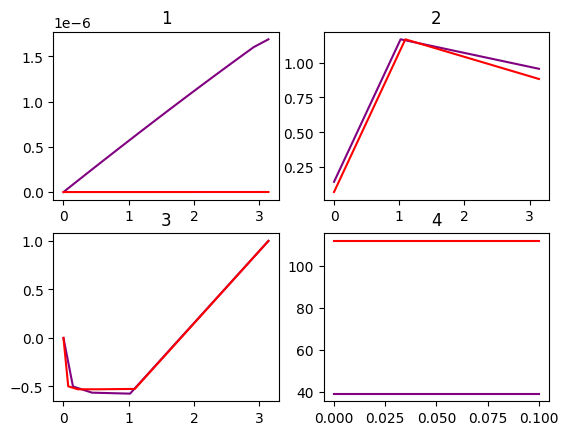

In [ ]:
show_graphics()